In [1]:
import scipy.io
import scipy.io.wavfile
import sounddevice as sd
import numpy as np
import soundfile as sf

import matplotlib 
matplotlib.use('TKagg')

%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
complete_mixture_length_in_s = 673194 / 16000
complete_mixture_length_in_s

42.074625

In [3]:
def play_from_filepath(fp, name='mixture', framerate=16000, start_in_s=0):
    sound = scipy.io.loadmat(fp)
    print('mixture shape: ' + (str(sound['earSout'].shape)))
    play_from_array(sound['earSout'], name, framerate, start_in_s=start_in_s)
    
    
def play_from_array(sound, name, framerate, start_in_s=0):
    start_frame = int(start_in_s * framerate)
    sound_arr = sound[start_frame:]
    # somehow try to invert the second axis - may resolve the feeling that the events happen on the left side
    #sound_arr = np.swapaxes(np.swapaxes(sound_arr, 0, sound_arr)[::-1], 0, 1)
    sf.write('demo_sound_{}_start{}s.wav'.format(name, str(start_in_s)), sound_arr, framerate)
    sd.play(sound_arr, framerate)

In [4]:
# master
fp = "/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat"
play_from_filepath(fp, 'mixture_TelephoneElectron+6037_36_3', start_in_s=25)

mixture shape: (673194, 2)


In [5]:
sd.stop()

In [6]:
SNR_MASTER = 0
SNR_DISTRACTOR1 = -20
SNR_DISTRACTOR2 = 12

def SNR_RATES(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2, SNR_DEVIATION_RATE = 0.9):
    SNR_BIGGEST = max(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)
    SNR_SMALLEST = min(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)
    SNR_DIFF = SNR_BIGGEST - SNR_SMALLEST

    SNR_MASTER *= SNR_DEVIATION_RATE
    SNR_DISTRACTOR1 *= SNR_DEVIATION_RATE
    SNR_DISTRACTOR2 *= SNR_DEVIATION_RATE
    
    if SNR_SMALLEST < 0:
        SNR_ADD = abs(SNR_SMALLEST)
        SNR_MASTER += SNR_ADD
        SNR_DISTRACTOR1 += SNR_ADD
        SNR_DISTRACTOR2 += SNR_ADD
    SNR_MASTER_RATE = SNR_MASTER / SNR_DIFF
    SNR_DISTRACTOR1_RATE = SNR_DISTRACTOR1 / SNR_DIFF
    SNR_DISTRACTOR2_RATE = SNR_DISTRACTOR2 / SNR_DIFF
    return SNR_MASTER_RATE, SNR_DISTRACTOR1_RATE, SNR_DISTRACTOR2_RATE

SNR_MASTER_RATE, SNR_DISTRACTOR1_RATE, SNR_DISTRACTOR2_RATE = SNR_RATES(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)

In [7]:
# distractor 1

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no2_CloseOutsideMic2.wav'
array, framerate = sf.read(fp) 
play_from_array(array, 'distractor1_no2', framerate, start_in_s=25-1.9219)
sd.stop()

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no3_BAG-PAPER_GEN-HDF-02778.wav'
onset = 32.850875
framerate, array = scipy.io.wavfile.read(fp)
play_from_array(array, 'distractor1_no3', framerate, start_in_s=0)
sd.stop()

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no4_ScissorPaper_DIGIF5-88.wav'
onset = 38.6094375
framerate, array = scipy.io.wavfile.read(fp)
time_sound = int((complete_mixture_length_in_s - onset) * framerate)
array = array[:time_sound, :]
play_from_array(array, 'distractor1_no4', framerate, start_in_s=0)
sd.stop()

# distractor 2

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor2_no3_CartoonFootsteps+4003_46_1.wav'
onset = 12.0458125
framerate, array = scipy.io.wavfile.read(fp)
time_sound = int((complete_mixture_length_in_s - onset) * framerate)
array = array[:time_sound, :]
play_from_array(array, 'distractor2_no3', framerate, start_in_s=25-12.0458)
sd.stop()

/Users/Heiner/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [8]:
def plot_from_array(sound, name, framerate, start_in_s=0, xlim=None, ylim=None, SNR_RATE=1, stereo=False, figsize=None):
    # Three subplots sharing both x/y axes
    if figsize is None:
        if not stereo:
            f, ax1 = plt.subplots(1, figsize=(11, 3))
        else:
            print('here')
            f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(11, 2))
    else:
        if not stereo:
            f, ax1 = plt.subplots(1, figsize=figsize)
        else:
            f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=figsize)
    
    start_frame = int(start_in_s * framerate)
    x = np.arange(start_frame, start_frame + sound.shape[0], 1)
    x = x / framerate
    
    if stereo:
        f.subplots_adjust(hspace=0)
    
    SNR_RATE = SNR_RATE ** (-1)
    
    ax1.plot(x, SNR_RATE*sound[:, 0])
    if stereo:
        ax2.plot(x, SNR_RATE*sound[:, 1])
    plt.setp([a.set_yticks([]) for a in f.axes[:]])
    if ylim is not None:
        plt.setp([a.set_ylim(ylim) for a in f.axes[:]])
    if xlim is not None:
        plt.setp([a.set_xlim(xlim) for a in f.axes[:]])
    if figsize is not None:
            plt.setp([a.set_xticks([]) for a in f.axes[:]])
    f.savefig(name + '.png', transparent=True, dpi=300)


In [9]:
def concat_sources(fps):
    arrays = []
    framerates = []
    for fp in fps:
        array, framerate = sf.read(fp) 
        shape = array.shape
        if len(shape) == 1: 
            array = array[:, np.newaxis]
            shape = array.shape
            if shape[1] == 1:
                array = np.repeat(array, 2, axis=1)
        arrays.append(array)
        framerates.append(framerate)
    if len(np.unique(np.array(framerates))) != 1:
        raise ValueError('Different framerates!')
    return arrays, framerates[0]

def merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result):
    result = np.full((last_frame, 2), 0.0)
    for array, start_frame_in_source, start_frame_in_result in zip(arrays, start_frames_in_source, start_frames_in_result):
        shape = array.shape
        length = shape[0] - start_frame_in_source
        if start_frame_in_result+length > last_frame:
            stop_in_result = last_frame
            stop_in_source = start_frame_in_source + (stop_in_result - start_frame_in_result)
        else:
            stop_in_result = start_frame_in_result+length
            stop_in_source = shape[0]
        result[start_frame_in_result:stop_in_result, :] = array[start_frame_in_source:stop_in_source, :]
    return result

In [10]:
# distractor 1

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no2_CloseOutsideMic2.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no3_BAG-PAPER_GEN-HDF-02778.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no4_ScissorPaper_DIGIF5-88.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-1.9219
start_frame_in_source_no2 = int(start_in_s * framerate)
start_frame_in_source_no3 = 0
start_frame_in_source_no4 = 0
start_frames_in_source = [start_frame_in_source_no2, start_frame_in_source_no3, start_frame_in_source_no4]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no2 = 0
start_frame_in_result_no3 = int((32.850875-25) * framerate)
start_frame_in_result_no4 = int((38.6094375-25) * framerate)
start_frames_in_result = [start_frame_in_result_no2, start_frame_in_result_no3, start_frame_in_result_no4]

result_distr1 = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

In [11]:
# distractor 2

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor2_no3_CartoonFootsteps+4003_46_1.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-12.0458125
start_frame_in_source_no3 = int(start_in_s * framerate)
start_frames_in_source = [start_frame_in_source_no3]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no3 = 0
start_frames_in_result = [start_frame_in_result_no3]

result_distr2 = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

In [12]:
# master

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/master_TelephoneElectron+6037_36_3.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/master_TelephoneElectron+6037_36_3.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-14.524875
start_frame_in_source_no2 = int(start_in_s * framerate)
start_frame_in_source_no3 = 0
start_frames_in_source = [start_frame_in_source_no2, start_frame_in_source_no3]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no2 = 0
start_frame_in_result_no3 = int((28.54975-25) * framerate)
start_frames_in_result = [start_frame_in_result_no2, start_frame_in_result_no3]

result_master = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

here




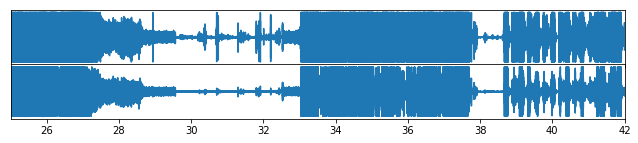

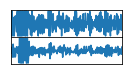

In [15]:
# mixture

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/demo_sound_mixture_TelephoneElectron+6037_36_3_start25s.wav']
arrays, framerate_mixture = concat_sources(fps)

start_frames_in_source = [0]

last_frame = int(complete_mixture_length_in_s * framerate_mixture) - int(25 * framerate_mixture)

start_frames_in_result = [0]

result_mixture = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)
plot_from_array(result_mixture, 'mixture_wav', framerate_mixture, start_in_s=25, xlim=(25, 42), SNR_RATE=1, stereo=True)

plot_from_array(result_mixture, 'mixture_wav_inner_20ms', framerate_mixture, start_in_s=25, xlim=(35, 35.02), figsize=(2, 1), SNR_RATE=1, stereo=True)


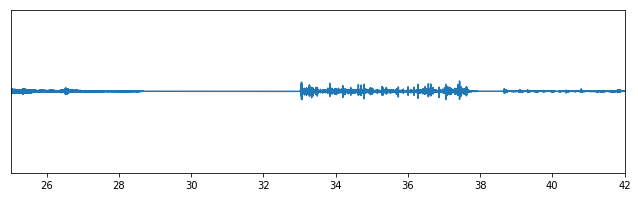

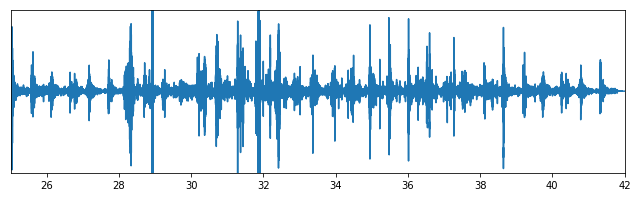

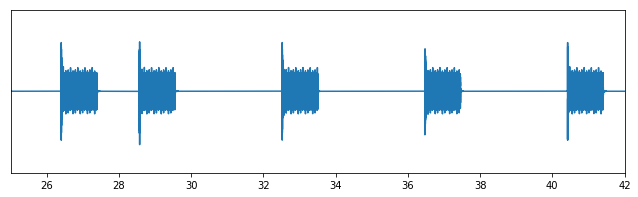

In [59]:
abs_max = np.abs(np.nanmax([np.nanmax(result_distr1)*SNR_DISTRACTOR1_RATE, np.nanmax(result_distr2)*SNR_DISTRACTOR2_RATE, np.nanmax(result_master)*SNR_MASTER_RATE]))
abs_min = np.abs(np.nanmin([np.nanmin(result_distr1)*SNR_DISTRACTOR1_RATE, np.nanmin(result_distr2)*SNR_DISTRACTOR2_RATE, np.nanmin(result_master)*SNR_MASTER_RATE]))
maxi = np.maximum(abs_max, abs_min)
ylim = (-maxi * 1.1, maxi * 1.1)

plot_from_array(result_distr1, 'distractor1', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=SNR_DISTRACTOR1_RATE)
plot_from_array(result_distr2, 'distractor2', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=3)
plot_from_array(result_master, 'master', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=0.45)

In [38]:
data = np.load('/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat.npz')

In [45]:
data['y'][0, 25*100:,:].shape
matched_data_part = np.repeat(data['y'][0, 25*100:,:], framerate_mixture / 100, axis=0)
matched_data = np.full((result_mixture.shape[0], 13), np.nan)
matched_data[:matched_data_part.shape[0], :] = matched_data_part
print(matched_data.shape)

labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'scream']

(273194, 13)


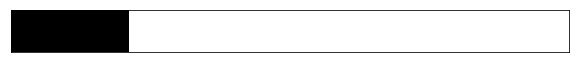

In [57]:
def plot_labels_head(matched_data, name, sparse=True, with_yticks=True):
    if not sparse:
        fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
        plot_data = np.copy(matched_data)
        if with_yticks:
            ax1.set_yticks(np.arange(0, 13))
            ax1.set_yticklabels(labels)
        else:
            ax1.set_yticks([])
            ax1.set_yticklabels([])
    else:
        non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
        fig, ax1 = plt.subplots(1,1, figsize=(10, (10/13)*len(non_empty)))
        non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
        plot_data = np.copy(matched_data)
        plot_data = plot_data[:, non_empty]
        if with_yticks:
            ax1.set_yticks(np.arange(0, len(non_empty)))
            ax1.set_yticklabels([labels[index] for index in non_empty])
        else:
            ax1.set_yticks([])
            ax1.set_yticklabels([])
    

    ax1.imshow(plot_data.T, cmap='Greys', aspect='auto')
    x = np.arange(framerate_mixture, plot_data.shape[0], 2*framerate_mixture)
    x_labels = np.arange(26, 44, 2)
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    xlim=((25-25), (42-25)*framerate_mixture)
    ax1.set_xlim(xlim)
    plt.savefig('label_'+name+'_for_head.svg', transparent=True, dpi=300)
    
plot_labels_head(matched_data[:, 10:11], 'piano_distr1', with_yticks=False)

In [18]:
# distr 1: piano, general, general
# distr 2: footsteps
# master: phone

In [19]:
labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'femaleScreammaleScream']

In [20]:
result_mixture.shape[0]

273194

In [21]:
# framerate pro sekunden
# framerate / 1000 pro millisekunde
# framerate / 100 pro 10 millisekunde

In [22]:
# ratemaps feat 0 - 31
# ams      feat 32 - 159

In [23]:
def timemapping(start_s, end_s, framerate_mixture):
    real_start = start_s - 25
    real_end = end_s - 25
    return real_start * framerate, real_end * framerate_mixture

In [24]:
data = np.load('/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat.npz')

matched_data_part = np.repeat(data['x'][0, 25*100:,:], framerate_mixture / 100, axis=0)
matched_data = np.full((result_mixture.shape[0], 160), np.nan)
matched_data[:matched_data_part.shape[0], :] = matched_data_part

ratemaps = matched_data[:, :32]
ams = matched_data[:, 32:]
matched_data.shape[0]

273194

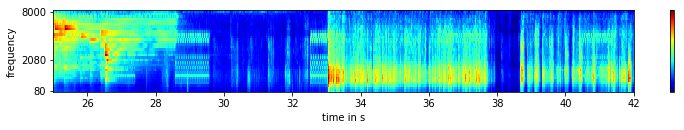

In [106]:
fig, ax1 = plt.subplots(1,1, figsize=(13, 1.5))
plot_data = np.copy(ratemaps)
ax1.set_yticks(np.array([0, 19, 31]))
ax1.set_yticklabels(np.array([8000, 2080, 80]))    
img = ax1.imshow(plot_data.T, aspect='auto', cmap='jet')
cb = plt.colorbar(img, ax=ax1)
cb.set_ticks([])
x = np.arange(framerate_mixture, plot_data.shape[0], 2*framerate_mixture)
x_labels = np.arange(26, 44, 2)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
xlim=((25-25), (42-25)*framerate_mixture)
ax1.set_xlim(xlim)
ax1.set_ylabel('frequency')
xlabel = ax1.set_xlabel('time in s')
fig.savefig('ratemap.png', transparent=True, bbox_extra_artists=[xlabel], bbox_inches='tight', dpi=300)

# zahlen raus

(273194, 16)


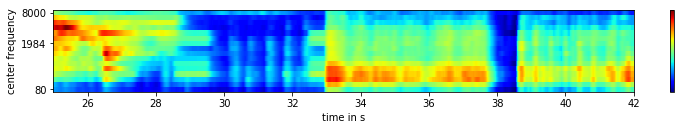

In [105]:
fig, ax1 = plt.subplots(1,1, figsize=(13, 1.5))
plot_data = np.copy(ams[:, :16])
print(plot_data.shape)
ax1.set_yticks(np.array([0, 6, 15]))
ax1.set_yticklabels(np.array([8000, 1984, 80]))    
img = ax1.imshow(plot_data.T, cmap='jet', aspect='auto')
cb = plt.colorbar(img, ax=ax1)
cb.set_ticks([])
x = np.arange(framerate_mixture, plot_data.shape[0], 2*framerate_mixture)
x_labels = np.arange(26, 44, 2)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
xlim=((25-25), (42-25)*framerate_mixture)
ax1.set_xlim(xlim)
ax1.set_ylabel('center frequency')
#ax1.set_title('modulation frequency 2')
xlabel = ax1.set_xlabel('time in s')

fig.savefig('ams.png', transparent=True, bbox_extra_artists=[xlabel], bbox_inches='tight', dpi=300)

In [27]:
data = np.load('/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat.npz')

In [28]:
data['y'][0, 25*100:,:].shape
matched_data_part = np.repeat(data['y'][0, 25*100:,:], framerate_mixture / 100, axis=0)
matched_data = np.full((result_mixture.shape[0], 13), np.nan)
matched_data[:matched_data_part.shape[0], :] = matched_data_part
matched_data.shape

labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'femaleScreammaleScream']

In [29]:
matched_data[matched_data == np.nan]

array([], dtype=float64)

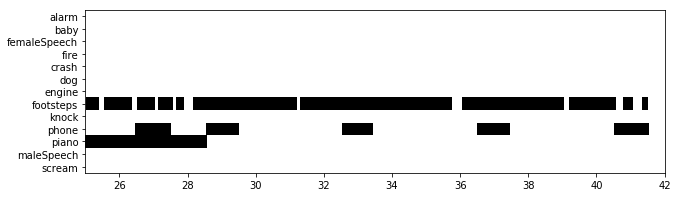

In [116]:
sparse = False


if not sparse:
    fig, ax1 = plt.subplots(1,1, figsize=(10.38, 3))
    plot_data = np.copy(matched_data)
    ax1.set_yticks(np.arange(0, 13))
    ax1.set_yticklabels(labels)

else:
    non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
    fig, ax1 = plt.subplots(1,1, figsize=(10, (5/13)*len(non_empty)))
    non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
    plot_data = np.copy(matched_data)
    plot_data = plot_data[:, non_empty]
    ax1.set_yticks(np.arange(0, len(non_empty)))
    ax1.set_yticklabels([labels[index] for index in non_empty])
    
ax1.imshow(plot_data.T, cmap='Greys', aspect='auto')
#ax1.grid(axis='y')
x = np.arange(framerate_mixture, plot_data.shape[0], 2*framerate_mixture)
x_labels = np.arange(26, 44, 2)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
xlim=((25-25), (42-25)*framerate_mixture)
ax1.set_xlim(xlim)
fig.savefig('labels.png', transparent=True, bbox_inches='tight', dpi=300)
# linien

In [31]:
sounds_path = '/Users/Heiner/mounted/binAudData/reposX/twoears-data/sound_databases/generalSoundsNI/'
import glob
import os.path

everything_in_dir = glob.glob(sounds_path+'*')
folders_in_dir = []

for name in everything_in_dir:
    if os.path.isdir(name):
        folders_in_dir.append(name)


In [32]:
folders_in_dir

[]

In [33]:
from tqdm import tqdm

counts_dir = dict()
lengths_dir = dict()

for folder in folders_in_dir:
    sound_class = folder.split('/')[-1]
    valid_files = [file for file in glob.glob(folder+'/*') if file.endswith('wav')]
    counts_dir[sound_class] = len(valid_files)
    #lengths = []
    #for valid_file in tqdm(valid_files):
    #    data, framerate = sf.read(valid_file)
    #    lengths.append(len(data) / framerate)
    #lengths_dir[sound_class] = lengths

In [34]:
counts_dir

{}

In [35]:
a = np.zeros((10, 2))

In [36]:
len(a)

10

In [37]:
min_max_lengths_dict = dict()
for key, lengths in lengths_dir.items():
    min_max_lengths_dict[key] = (np.min(lengths), np.max(lengths))

In [38]:
min_max_lengths_dict

{}

In [39]:
sum = 0
for key, count in counts_dir.items():
    if key != 'general':
        sum += count
sum

0

In [40]:
sum_lengths_dict = dict()
for key, lengths in lengths_dir.items():
    sum_lengths_dict[key] = np.sum(lengths)

In [41]:
sum_lengths_dict

{}

In [42]:
sum_lengths = 0
for key, length in sum_lengths_dict.items():
    if key != 'general':
        sum_lengths += length
sum_lengths        

0

In [43]:
import pickle
file_lengths = pickle.load( open( "/Users/Heiner/repos/binaural_audition/common/data/data_creation/file_lengths.pickle", "rb" ) )

In [44]:
count_lengths_dict = dict()
for _, length in file_lengths.items():
    if length not in count_lengths_dict:
        count_lengths_dict[length] = 1
    else:
        count_lengths_dict[length] += 1

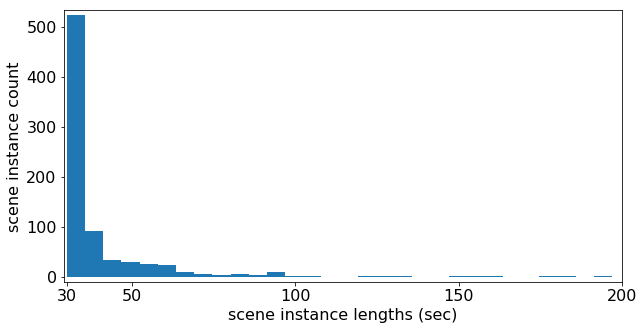

In [151]:
scene = 39
counts = np.array([length for filename, length in file_lengths.items() if 'scene'+str(scene) in filename])
counts = counts / 100

f, ax = plt.subplots(figsize=(10,5))
bins = 30
hist_max = np.max(np.histogram(counts, bins=bins)[0])
n, bins, patches = ax.hist(counts, bins=bins)
ax.set_ylim((-10, hist_max+10))
ax.set_xticks([30, 50, 100, 150, 200])
ax.set_xlim((29, 200))
ax.set_ylabel('scene instance count')
xlabel = plt.xlabel('scene instance lengths (sec)')#
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.savefig('scene_instance_lengths.png', transparent=True, bbox_extra_artists=[xlabel], bbox_inches='tight', dpi=300)

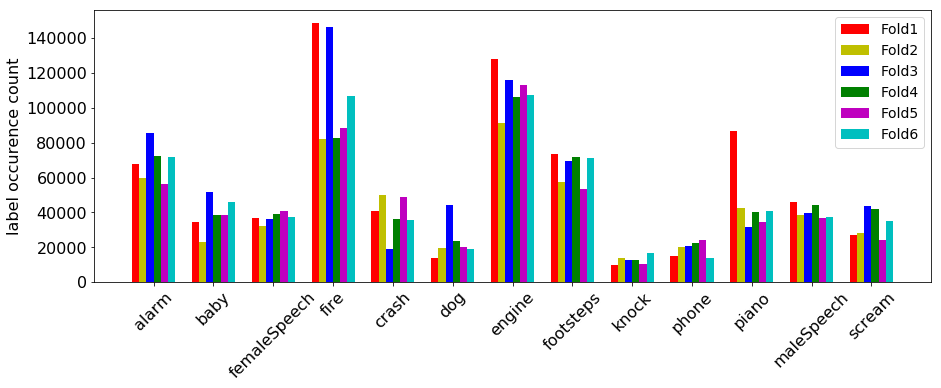

In [167]:
train_weights = np.load("/Users/Heiner/repos/binaural_audition/common/data/data_creation/train_weights_blockbased.npy")

scene = 39
pos_train_weights_in_scene = train_weights[:, scene-1, :, 0]
pos_train_weights_in_scene.shape

labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'scream']

N = 13

ind = np.arange(N)  # the x locations for the groups
width = 0.12     # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))

fold1_pos = pos_train_weights_in_scene[0, :]
rects1 = ax.bar(ind, fold1_pos, width, color='r')

fold2_pos = pos_train_weights_in_scene[1, :]
rects2 = ax.bar(ind + width, fold2_pos, width, color='y')

fold3_pos = pos_train_weights_in_scene[2, :]
rects3 = ax.bar(ind + 2*width, fold3_pos, width, color='b')

fold4_pos = pos_train_weights_in_scene[3, :]
rects4 = ax.bar(ind + 3*width, fold4_pos, width, color='g')

fold5_pos = pos_train_weights_in_scene[4, :]
rects5 = ax.bar(ind + 4*width, fold5_pos, width, color='m')

fold6_pos = pos_train_weights_in_scene[5, :]
rects6 = ax.bar(ind + 5*width, fold6_pos, width, color='c')

# add some text for labels, title and axes ticks
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + 5*width / 2)
ax.set_xticklabels(labels, rotation=45)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0], rects6[0]), ('Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5', 'Fold6'), fontsize=14)
ax.set_ylabel('label occurence count')

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
fig.savefig('label_occurence.png', transparent=True, bbox_inches='tight', dpi=300)

#